In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 227 (delta 65), reused 170 (delta 32), pack-reused 0
Receiving objects: 100% (227/227), 11.01 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
!pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 25.8 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning/best_params_knn_item.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/pure_svd_params.json
/kaggle/input/hyperparameters-tuning/submission.csv
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/best_params_knn_user.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2156


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': False,
    'tune_parameters_pure_svd': False,
    'tune_parameters_ials': True,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'train_best_models': False,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/RecSys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


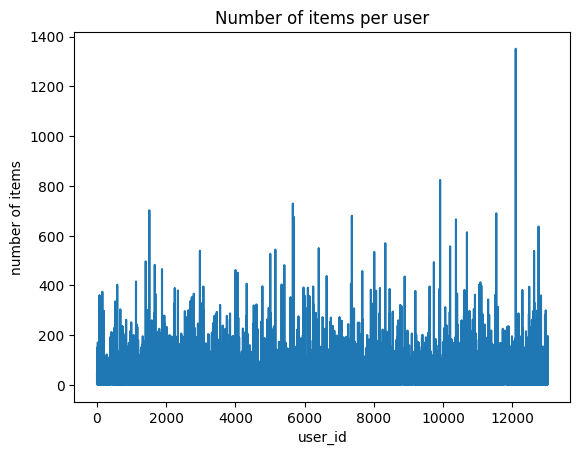

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

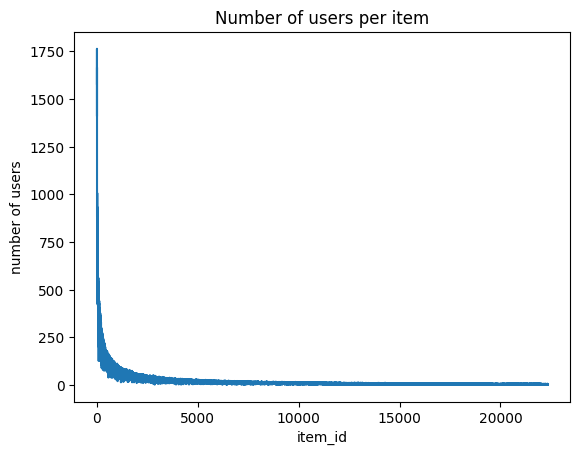

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [24]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [25]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [26]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [27]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

## Item KNN Collaborative Filtering

In [30]:
def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = ItemKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        print(f'MAP is {result_df.loc[10, "MAP"]}')
        map_sum += result_df.loc[10, 'MAP']
        
    return map_sum / 10

In [31]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=75)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [32]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [36]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [37]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [38]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [42]:
%%time

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        map_sum = 0
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            recommender = PureSVDRecommender(URM_train)
            recommender.fit(num_factors=factors)

            evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
            result_df, _ = evaluator.evaluateRecommender(recommender)
            map_sum += result_df.loc[10, 'MAP']
        map_results.append(map_sum / 10)
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {result_df.loc[10, "MAP"]}')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [43]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender');

In [44]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    try:
        shutil.copyfile(
            '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
            '/kaggle/working/pure_svd_params.json'
        )
    except FileNotFoundError:
        pass # not already tuned

# Alternating Least Squares

In [45]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-5, 0.1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    num_factors = trial.suggest_int('num_factors', 10, 100)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 3,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [46]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=10)

[I 2023-11-19 10:41:00,464] A new study created in RDB with name: hyperparameters_tuning_ials


EvaluatorHoldout: Ignoring 4043 (31.0%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 500 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 172 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8981 (100.0%) in 6.42 sec. Users per second: 1400
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0153435, PRECISION_RECALL_MIN_DEN: 0.0391570, RECALL: 0.0373189, MAP: 0.0057345, MAP_MIN_DEN: 0.0146867, MRR: 0.0502229, NDCG: 0.0289117, F1: 0.0217462, HIT_RATE: 0.1351743, ARHR_ALL_HITS: 0.0536500, NOVELTY: 0.0042250, AVERAGE_POPULARITY: 0.4503759, DIVERSITY_MEAN_INTER_LIST: 0.8641892, DIVERSITY_HERFINDAHL: 0.9864093, COVERAGE_ITEM: 0.0186155, COVERAGE_ITEM_HIT: 0.0062648, ITEMS_IN_GT: 0.6097910, COVERAGE_USER: 0.6895731, COVERAGE_USER_HIT: 0.0932125, USERS_IN_GT: 0.6895731, DIVERSITY_GINI: 0.0038445, SHANNON_ENTROPY: 6.8211631, RATIO_DIVERSITY_HERFINDAHL: 0.9867658, RATIO_DIVERSITY_GINI: 0.0110296, RATIO_

[I 2023-11-19 11:11:08,495] Trial 0 finished with value: 0.009499598269778168 and parameters: {'reg': 0.0016847803553561164, 'alpha': 0.5146444934394272, 'num_factors': 40}. Best is trial 0 with value: 0.009499598269778168.


EvaluatorHoldout: Ignoring 4056 (31.1%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 497 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 173 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8968 (100.0%) in 6.31 sec. Users per second: 1422
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0139607, PRECISION_RECALL_MIN_DEN: 0.0358541, RECALL: 0.0342000, MAP: 0.0054629, MAP_MIN_DEN: 0.0139568, MRR: 0.0479892, NDCG: 0.0270411, F1: 0.0198277, HIT_RATE: 0.1236619, ARHR_ALL_HITS: 0.0512161, NOVELTY: 0.0042372, AVERAGE_POPULARITY: 0.4153952, DIVERSITY_MEAN_INTER_LIST: 0.8929025, DIVERSITY_HERFINDAHL: 0.9892803, COVERAGE_ITEM: 0.0436748, COVERAGE_ITEM_HIT: 0.0070703, ITEMS_IN_GT: 0.6111335, COVERAGE_USER: 0.6885749, COVERAGE_USER_HIT: 0.0851505, USERS_IN_GT: 0.6885749, DIVERSITY_GINI: 0.0056979, SHANNON_ENTROPY: 7.3140612, RATIO_DIVERSITY_HERFINDAHL: 0.9896370, RATIO_DIVERSITY_GINI: 0.0163330, RATIO_

[I 2023-11-19 11:46:21,193] Trial 1 finished with value: 0.01296412318054419 and parameters: {'reg': 0.00026869329224418786, 'alpha': 0.761526331751294, 'num_factors': 27}. Best is trial 1 with value: 0.01296412318054419.


EvaluatorHoldout: Ignoring 3991 (30.6%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 501 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 175 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9033 (100.0%) in 6.80 sec. Users per second: 1329
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0171814, PRECISION_RECALL_MIN_DEN: 0.0448552, RECALL: 0.0430765, MAP: 0.0065714, MAP_MIN_DEN: 0.0169137, MRR: 0.0572441, NDCG: 0.0330871, F1: 0.0245650, HIT_RATE: 0.1505591, ARHR_ALL_HITS: 0.0612216, NOVELTY: 0.0042547, AVERAGE_POPULARITY: 0.4120815, DIVERSITY_MEAN_INTER_LIST: 0.8971970, DIVERSITY_HERFINDAHL: 0.9897098, COVERAGE_ITEM: 0.0327113, COVERAGE_ITEM_HIT: 0.0089050, ITEMS_IN_GT: 0.6101490, COVERAGE_USER: 0.6935657, COVERAGE_USER_HIT: 0.1044226, USERS_IN_GT: 0.6935657, DIVERSITY_GINI: 0.0053211, SHANNON_ENTROPY: 7.2738848, RATIO_DIVERSITY_HERFINDAHL: 0.9900669, RATIO_DIVERSITY_GINI: 0.0152643, RATIO_

[I 2023-11-19 12:04:44,835] Trial 2 finished with value: 0.003959843202976646 and parameters: {'reg': 0.007926281573747803, 'alpha': 0.6087275245165898, 'num_factors': 81}. Best is trial 1 with value: 0.01296412318054419.


EvaluatorHoldout: Ignoring 4027 (30.9%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 495 ( 3.8%) users with no interactions.
IALSRecommender: URM Detected 170 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8997 (100.0%) in 6.46 sec. Users per second: 1393
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0133934, PRECISION_RECALL_MIN_DEN: 0.0348634, RECALL: 0.0332670, MAP: 0.0048113, MAP_MIN_DEN: 0.0130362, MRR: 0.0439540, NDCG: 0.0255539, F1: 0.0190979, HIT_RATE: 0.1210403, ARHR_ALL_HITS: 0.0459874, NOVELTY: 0.0042400, AVERAGE_POPULARITY: 0.4036225, DIVERSITY_MEAN_INTER_LIST: 0.8972361, DIVERSITY_HERFINDAHL: 0.9897136, COVERAGE_ITEM: 0.0437643, COVERAGE_ITEM_HIT: 0.0080995, ITEMS_IN_GT: 0.6169956, COVERAGE_USER: 0.6908016, COVERAGE_USER_HIT: 0.0836149, USERS_IN_GT: 0.6908016, DIVERSITY_GINI: 0.0058755, SHANNON_ENTROPY: 7.3707406, RATIO_DIVERSITY_HERFINDAHL: 0.9900722, RATIO_DIVERSITY_GINI: 0.0168780, RATIO_

[I 2023-11-19 12:39:12,857] Trial 3 finished with value: 0.013086770187427623 and parameters: {'reg': 0.0020737168432049544, 'alpha': 0.9885378310001731, 'num_factors': 31}. Best is trial 3 with value: 0.013086770187427623.


EvaluatorHoldout: Ignoring 4016 (30.8%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 477 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 180 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9008 (100.0%) in 5.13 sec. Users per second: 1757
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0000111, PRECISION_RECALL_MIN_DEN: 0.0000555, RECALL: 0.0000555, MAP: 0.0000019, MAP_MIN_DEN: 0.0000093, MRR: 0.0000185, NDCG: 0.0000242, F1: 0.0000185, HIT_RATE: 0.0001110, ARHR_ALL_HITS: 0.0000185, NOVELTY: 0.0000000, AVERAGE_POPULARITY: 0.0000000, DIVERSITY_MEAN_INTER_LIST: 0.9398709, DIVERSITY_HERFINDAHL: 0.9939753, COVERAGE_ITEM: 0.0080548, COVERAGE_ITEM_HIT: 0.0000447, ITEMS_IN_GT: 0.6125654, COVERAGE_USER: 0.6915694, COVERAGE_USER_HIT: 0.0000768, USERS_IN_GT: 0.6916462, DIVERSITY_GINI: 0.0067745, SHANNON_ENTROPY: 7.4312395, RATIO_DIVERSITY_HERFINDAHL: 0.9943349, RATIO_DIVERSITY_GINI: 0.0194491, RATIO_

[I 2023-11-19 13:08:15,710] Trial 4 finished with value: 0.007583989916935345 and parameters: {'reg': 3.9246629632406776e-05, 'alpha': 0.18441362328385447, 'num_factors': 83}. Best is trial 3 with value: 0.013086770187427623.


EvaluatorHoldout: Ignoring 4027 (30.9%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 484 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 178 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 8997 (100.0%) in 6.60 sec. Users per second: 1364
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0163610, PRECISION_RECALL_MIN_DEN: 0.0436469, RECALL: 0.0418272, MAP: 0.0059598, MAP_MIN_DEN: 0.0162649, MRR: 0.0526702, NDCG: 0.0315005, F1: 0.0235214, HIT_RATE: 0.1452706, ARHR_ALL_HITS: 0.0559929, NOVELTY: 0.0042480, AVERAGE_POPULARITY: 0.4280768, DIVERSITY_MEAN_INTER_LIST: 0.8856691, DIVERSITY_HERFINDAHL: 0.9885571, COVERAGE_ITEM: 0.0249698, COVERAGE_ITEM_HIT: 0.0078310, ITEMS_IN_GT: 0.6126549, COVERAGE_USER: 0.6908016, COVERAGE_USER_HIT: 0.1003532, USERS_IN_GT: 0.6908016, DIVERSITY_GINI: 0.0045703, SHANNON_ENTROPY: 7.0724607, RATIO_DIVERSITY_HERFINDAHL: 0.9889140, RATIO_DIVERSITY_GINI: 0.0131051, RATIO_

[I 2023-11-19 13:59:24,390] Trial 5 finished with value: 0.013861312700633838 and parameters: {'reg': 0.010197254827136416, 'alpha': 0.8732142869332377, 'num_factors': 77}. Best is trial 5 with value: 0.013861312700633838.


EvaluatorHoldout: Ignoring 4012 (30.8%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 482 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 173 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9012 (100.0%) in 4.98 sec. Users per second: 1809
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0000333, PRECISION_RECALL_MIN_DEN: 0.0000806, RECALL: 0.0000806, MAP: 0.0000063, MAP_MIN_DEN: 0.0000130, MRR: 0.0000632, NDCG: 0.0000447, F1: 0.0000471, HIT_RATE: 0.0003329, ARHR_ALL_HITS: 0.0000632, NOVELTY: 0.0000000, AVERAGE_POPULARITY: 0.0000000, DIVERSITY_MEAN_INTER_LIST: 0.9369334, DIVERSITY_HERFINDAHL: 0.9936731, COVERAGE_ITEM: 0.0077415, COVERAGE_ITEM_HIT: 0.0001342, ITEMS_IN_GT: 0.6072851, COVERAGE_USER: 0.6914158, COVERAGE_USER_HIT: 0.0002303, USERS_IN_GT: 0.6919533, DIVERSITY_GINI: 0.0064434, SHANNON_ENTROPY: 7.3658828, RATIO_DIVERSITY_HERFINDAHL: 0.9940321, RATIO_DIVERSITY_GINI: 0.0184827, RATIO_

[I 2023-11-19 14:24:11,920] Trial 6 finished with value: 0.007609840614576206 and parameters: {'reg': 0.04437552846655995, 'alpha': 0.8670045680250776, 'num_factors': 60}. Best is trial 5 with value: 0.013861312700633838.


EvaluatorHoldout: Ignoring 4003 (30.7%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 479 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 173 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9021 (100.0%) in 6.39 sec. Users per second: 1412
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0157854, PRECISION_RECALL_MIN_DEN: 0.0412074, RECALL: 0.0393926, MAP: 0.0060698, MAP_MIN_DEN: 0.0159063, MRR: 0.0534335, NDCG: 0.0307359, F1: 0.0225390, HIT_RATE: 0.1387873, ARHR_ALL_HITS: 0.0569322, NOVELTY: 0.0041985, AVERAGE_POPULARITY: 0.4429485, DIVERSITY_MEAN_INTER_LIST: 0.8671061, DIVERSITY_HERFINDAHL: 0.9867010, COVERAGE_ITEM: 0.0438090, COVERAGE_ITEM_HIT: 0.0071598, ITEMS_IN_GT: 0.6084486, COVERAGE_USER: 0.6926443, COVERAGE_USER_HIT: 0.0961302, USERS_IN_GT: 0.6926443, DIVERSITY_GINI: 0.0048542, SHANNON_ENTROPY: 7.0348520, RATIO_DIVERSITY_HERFINDAHL: 0.9870577, RATIO_DIVERSITY_GINI: 0.0139256, RATIO_

[I 2023-11-19 14:53:47,283] Trial 7 finished with value: 0.011827402455181501 and parameters: {'reg': 0.0538740449330608, 'alpha': 0.12663697128102985, 'num_factors': 27}. Best is trial 5 with value: 0.013861312700633838.


EvaluatorHoldout: Ignoring 3989 (30.6%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 480 ( 3.7%) users with no interactions.
IALSRecommender: URM Detected 174 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9035 (100.0%) in 6.55 sec. Users per second: 1379
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0159602, PRECISION_RECALL_MIN_DEN: 0.0439557, RECALL: 0.0422657, MAP: 0.0057673, MAP_MIN_DEN: 0.0155765, MRR: 0.0498280, NDCG: 0.0307218, F1: 0.0231707, HIT_RATE: 0.1394577, ARHR_ALL_HITS: 0.0535892, NOVELTY: 0.0042608, AVERAGE_POPULARITY: 0.4223588, DIVERSITY_MEAN_INTER_LIST: 0.8916217, DIVERSITY_HERFINDAHL: 0.9891523, COVERAGE_ITEM: 0.0273862, COVERAGE_ITEM_HIT: 0.0081443, ITEMS_IN_GT: 0.6096568, COVERAGE_USER: 0.6937193, COVERAGE_USER_HIT: 0.0967445, USERS_IN_GT: 0.6937193, DIVERSITY_GINI: 0.0048610, SHANNON_ENTROPY: 7.1594082, RATIO_DIVERSITY_HERFINDAHL: 0.9895099, RATIO_DIVERSITY_GINI: 0.0139422, RATIO_

[I 2023-11-19 15:18:06,783] Trial 8 finished with value: 0.00726815252715581 and parameters: {'reg': 5.836429107978068e-05, 'alpha': 0.6015480922249757, 'num_factors': 75}. Best is trial 5 with value: 0.013861312700633838.


EvaluatorHoldout: Ignoring 4008 (30.8%) Users that have less than 1 test interactions
IALSRecommender: URM Detected 470 ( 3.6%) users with no interactions.
IALSRecommender: URM Detected 170 ( 0.8%) items with no interactions.
IALSRecommender: Validation begins...
EvaluatorHoldout: Processed 9016 (100.0%) in 5.13 sec. Users per second: 1757
IALSRecommender: CUTOFF: 10 - PRECISION: 0.0000111, PRECISION_RECALL_MIN_DEN: 0.0000111, RECALL: 0.0000053, MAP: 0.0000111, MAP_MIN_DEN: 0.0000111, MRR: 0.0001109, NDCG: 0.0000244, F1: 0.0000072, HIT_RATE: 0.0001109, ARHR_ALL_HITS: 0.0001109, NOVELTY: 0.0000537, AVERAGE_POPULARITY: 0.0000233, DIVERSITY_MEAN_INTER_LIST: 0.9369603, DIVERSITY_HERFINDAHL: 0.9936856, COVERAGE_ITEM: 0.0080548, COVERAGE_ITEM_HIT: 0.0000447, ITEMS_IN_GT: 0.6092093, COVERAGE_USER: 0.6922604, COVERAGE_USER_HIT: 0.0000768, USERS_IN_GT: 0.6922604, DIVERSITY_GINI: 0.0064529, SHANNON_ENTROPY: 7.3798735, RATIO_DIVERSITY_HERFINDAHL: 0.9940441, RATIO_DIVERSITY_GINI: 0.0185001, RATIO_

[I 2023-11-19 15:29:23,731] Trial 9 finished with value: 0.0012764641144218122 and parameters: {'reg': 0.00011018168548729523, 'alpha': 0.6720610696607968, 'num_factors': 71}. Best is trial 5 with value: 0.013861312700633838.


CPU times: user 7h 23min 18s, sys: 5h 13min 14s, total: 12h 36min 32s
Wall time: 4h 48min 24s


In [47]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [48]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [49]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [50]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials.json', 
            'tuning_results/best_params_ials.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials.json', 
        '/kaggle/working/best_params_ials.json'
    )

In [51]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [52]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [53]:
# user_ids_test.info()

In [54]:
# user_ids_test.head(5)

In [55]:
# user_ids_test['user_id'].unique()

In [56]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [57]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)